In [1]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd
import numpy as np
import re
import json
import codecs
import word2vecReader as godin_embedding
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import load_model
import keras.backend as K
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
%matplotlib inline

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#loading data
def load_data_from_file(filename):
    print("loading file = ",filename)
    with open(filename,'r') as f:
        foo = json.load(f)
    return foo['sentence'],foo['labels']

In [3]:
dataX,dataY = load_data_from_file('dataset/final_dev.json')

loading file =  dataset/final_dev.json


In [4]:
print('data len')
print(len(dataX),len(dataY))

data len
111 111


In [5]:
print('count 1,count 0')
print(dataY.count(1),dataY.count(0))

count 1,count 0
49 62


In [6]:
def remove_punctuation(s):
    list_punctuation = list(punctuation.replace('$',''))
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [7]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    tokens = [remove_punctuation(w) for w in tokens]
#     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [8]:
print('cleaning train set')
dataX = [clean_sentence(x) for x in dataX]

cleaning train set


In [9]:
# trainY

In [10]:
dataY = to_categorical(dataY,2)

In [11]:
# trainY

In [12]:
# lengths = [len(s.split()) for s in dataX]
max_length = 27

In [13]:
max_length

27

In [14]:
def load_google_word2vec(file_name):
    print("Loading word2vec model, this can take some time...")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [15]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading goding model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [16]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

Loading word2vec model, this can take some time...


In [17]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")

Loading goding model, this can take some time...


In [18]:
def get_embedding_matrix(model,sentence,godin_flag = False):
    tokens = sentence.split()[:max_length]
    if godin_flag:
        embedding_matrix = np.zeros((max_length,400))
    else:
        embedding_matrix = np.zeros((max_length,300))
    for i,word in enumerate(tokens):
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [29]:
print("bulding word2vec matrix of train set")
train_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x) for x in dataX])
print("bulding godin matrix of train set")
train_godin = np.asarray([get_embedding_matrix(godin_model,x,godin_flag=True) for x in dataX])

bulding word2vec matrix of train set
bulding godin matrix of train set


In [ ]:
input_array

In [20]:
# with open('top20models/emb_key.json') as f:
#     top_models = json.load(f)

In [21]:
# def get_prediction_of_top_n_model(n):
#     pred_n = []
#     for x in range(1,n+1):
#         print('predicting for model rank',x)
#         model_name = top_models[str(x)]['key']
#         model_embeddings = top_models[str(x)]['embeddings']
#         input_array = [train_word2vec if x=='embedding_matrix_word2vec' else train_godin for x in model_embeddings]
#         model = load_model('top20models/'+str(model_name)+'.h5')
#         pred_n.append(model.predict(input_array))
#         del model
#     return pred_n

In [22]:
def get_ensemble_pred(pred_n):
    pred = []
    n_of_pred = len(pred_n)
    n_of_sampels = len(pred_n[0])
    for x in range(n_of_sampels):
        sum_0 = 0.0
        sum_1 = 0.0
        for v in pred_n:
            sum_0+=v[x][0]
            sum_1+=v[x][1]
        pred.append(np.asarray([sum_0/n_of_pred,sum_1/n_of_pred],dtype=np.float32))
    return np.asarray(pred,dtype=np.float32)

In [23]:
def get_acc(pred,dataY):
    pred_class = np.asarray([np.asarray([1,0],dtype=np.float32) if x[0]>x[1] else np.asarray([0,1],dtype=np.float32) for x in pred])
    count = [True if x[0]==y[0] else False for x,y in zip(pred_class,dataY)]
    return float(count.count(True))/len(count)

In [233]:
# pred_n = get_prediction_of_top_n_model(3)

In [234]:
# pred = get_ensemble_pred(pred_n)

In [235]:
# get_acc(pred,dataY)

In [24]:
no_of_top_models = []
acc_score = []
n_of_top_model_to_use = 20
pred_n = get_prediction_of_top_n_model(n_of_top_model_to_use)
print("now doing ensemble")
for i in range(1,n_of_top_model_to_use+1):
    no_of_top_models.append(i)
    pred = get_ensemble_pred(pred_n[:i])
    acc_score.append(get_acc(pred,dataY))

predicting for model rank 1
predicting for model rank 2
predicting for model rank 3
predicting for model rank 4
predicting for model rank 5
predicting for model rank 6
predicting for model rank 7
predicting for model rank 8
predicting for model rank 9
predicting for model rank 10
predicting for model rank 11
predicting for model rank 12
predicting for model rank 13
predicting for model rank 14
predicting for model rank 15
predicting for model rank 16
predicting for model rank 17
predicting for model rank 18
predicting for model rank 19
predicting for model rank 20
now doing ensemble


In [25]:
no_of_top_models

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [26]:
acc_score

[0.8918918918918919,
 0.8468468468468469,
 0.8558558558558559,
 0.8468468468468469,
 0.8558558558558559,
 0.8738738738738738,
 0.8918918918918919,
 0.8828828828828829,
 0.8738738738738738,
 0.8738738738738738,
 0.8738738738738738,
 0.8828828828828829,
 0.8828828828828829,
 0.8828828828828829,
 0.8738738738738738,
 0.8918918918918919,
 0.8918918918918919,
 0.8738738738738738,
 0.8738738738738738,
 0.8738738738738738]

Text(0,0.5,'accuracy')

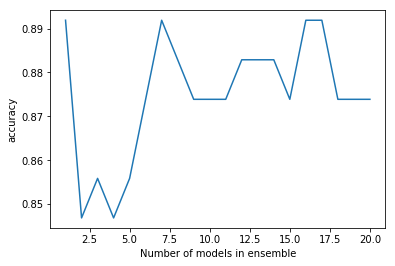

In [28]:
plt.plot(no_of_top_models, acc_score)
plt.xlabel('Number of models in ensemble')
plt.ylabel('accuracy')

0.7946428571428571

In [133]:
# model_name = top_models[str(1)]['key']
# model_name

In [134]:
# model_embeddings = top_models[str(1)]['embeddings']
# model_embeddings

In [135]:
# input_array = [train_word2vec if x=='embedding_matrix_word2vec' else train_godin for x in model_embeddings]

In [136]:
# model = load_model('top20models/'+str(model_name)+'.h5')

In [137]:
# pred = model.predict(input_array)

In [139]:
# get_acc(pred,dataY)